In [15]:
import os
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import util
from modules import RotationLSH, RandomForestClustRegressor, PictureResolver

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate training sample

In [11]:
data_dir = '../data/Set14'
files = ['barbara.png', 'bridge.png', 'comic.png', 'pepper.png', 'man.png']

np.random.seed(7)

n_samples = 20000
s = 1/2
X = []
Y = []
for file in files:
    path = os.path.join(data_dir, file)
    img_h = util.load_image(path)
    shape = img_h.shape
    new_shape = tuple(dim - (dim % int(1/s)) for dim in shape) # so that the HR and LR images have same size
    img_h = img_h[0:new_shape[0], 0:new_shape[1]]
    img_l = util.resize(util.resize(img_h, s), 1/s) # downsample -> upsample
    
    features = util.get_features(img_l)
    img_out_delta = img_h - img_l
    assert img_h.shape == img_l.shape == img_out_delta.shape == new_shape
    
    x_ind = np.random.randint(0, new_shape[0]-9, size=n_samples//len(files))
    y_ind = np.random.randint(0, new_shape[1]-9, size=n_samples//len(files))
    for x, y in zip(x_ind, y_ind):
        feat_patch = features[x:x+9, y:y+9]
        delta_patch = img_out_delta[x:x+9, y:y+9]
        X.append(feat_patch.flatten())
        Y.append(delta_patch.flatten())
    
X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(20000, 486)
(20000, 81)


## Train and evaluate model

In [7]:
# X = np.random.randn(10000, 486)
# Y = np.random.randn(10000, 81)

In [12]:
%%time

lsh = RotationLSH()
X_comp = lsh.fit_transform(X, n_iter=20)

rf = RandomForestClustRegressor(
    min_samples_leaf=128,
    alpha=1
)
rf.fit(X, X_comp, Y)

C:\Anaconda3\envs\main-env\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\envs\main-env\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\envs\main-env\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\envs\main-env\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want t

Wall time: 1h 21min 40s


In [13]:
with open('rf.pkl', 'wb') as output:
    pickle.dump(rf, output, pickle.HIGHEST_PROTOCOL)

C:\Users\jurg96\Desktop\Skoltech\Machine Learning\Project\FARF\modules\PictureResolver.py:60: RuntimeWarning: invalid value encountered in true_divide
  return img_in + img_out_delta


Text(0.5, 0, 'Difference')

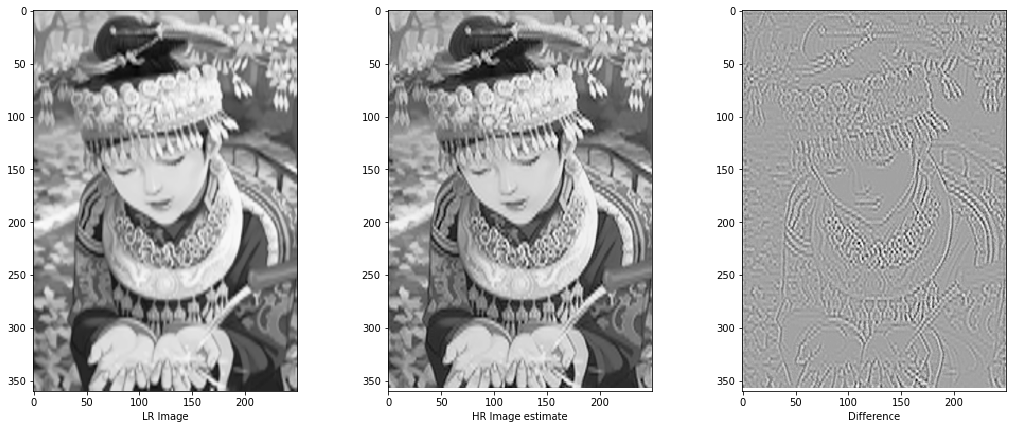

In [18]:
path_test = os.path.join(data_dir, 'comic.png')
img_test = util.load_image(path_test)
x = util.resize(util.resize(img_test, s), 1/s)

pr = PictureResolver(rf, lsh)
y = pr.resolve(x)

fig, ax = plt.subplots(1,3, figsize=(18,7))
ax[0].imshow(x, cmap='Greys_r')
ax[1].imshow(y, cmap='Greys_r')
ax[2].imshow(y-x, cmap='Greys_r')

ax[0].set_xlabel('LR Image')
ax[1].set_xlabel('HR Image estimate')
ax[2].set_xlabel('Difference')

Text(0.5, 0, 'Difference')

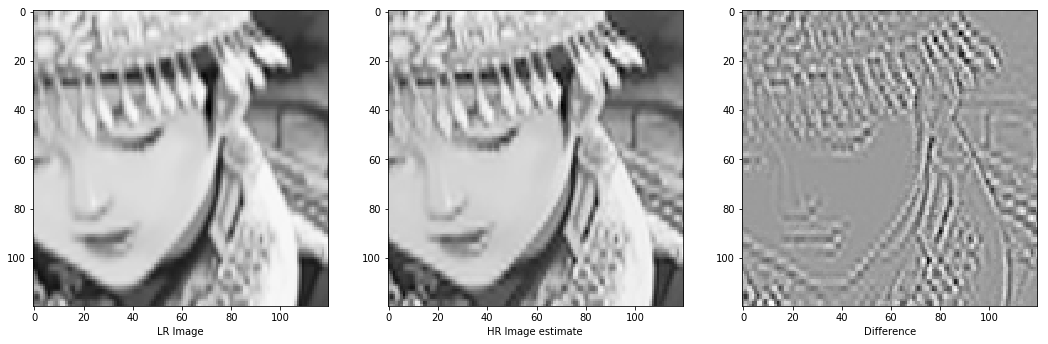

In [19]:
x_slice = slice(90,210)
y_slice = slice(90,210)

fig, ax = plt.subplots(1,3, figsize=(18,7))
ax[0].imshow(x[x_slice,y_slice], cmap='Greys_r')
ax[1].imshow(y[x_slice,y_slice], cmap='Greys_r')
ax[2].imshow((y-x)[x_slice,y_slice], cmap='Greys_r')

ax[0].set_xlabel('LR Image')
ax[1].set_xlabel('HR Image estimate')
ax[2].set_xlabel('Difference')